In [71]:
# %%
import os
import sys
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import json
from harp.clock import decode_harp_clock, align_timestamps_to_anchor_points
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import re
from utils.beh_functions import parseSessionID, session_dirs
from utils.plot_utils import shiftedColorMap, template_reorder
from open_ephys.analysis import Session##
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.postprocessing as spost
import spikeinterface.widgets as sw
from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import load_nwb
from aind_ephys_utils import align
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
from matplotlib import colormaps
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename
from spikeinterface.core.sorting_tools import random_spikes_selection
import pickle
import datetime
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.postprocessing as spost
from tqdm import tqdm
import spikeinterface.widgets as sw
%matplotlib inline

In [72]:
plt.close('all')
session = 'behavior_751004_2024-12-20_13-26-11'
data_type = 'curated'
target = 'soma'
session_dir = session_dirs(session)
we = si.load(session_dir['postprocessed_dir_curated'], load_extensions=False)

/opt/conda/lib/python3.10/site-packages/spikeinterface/core/base.py:1109: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.101.2 is recommended
  warnings.warn(


In [73]:
pkl_wf = '/root/capsule/scratch/751004/behavior_751004_2024-12-20_13-26-11/ephys/opto/curated/behavior_751004_2024-12-20_13-26-11_opto_waveform_metrics.pkl'
with open(pkl_wf, 'rb') as f:
    wf_tbl = pickle.load(f) 
    wf_tbl = wf_tbl.apply(pd.to_numeric, errors='ignore')

/tmp/ipykernel_23480/3737636290.py:4: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  wf_tbl = wf_tbl.apply(pd.to_numeric, errors='ignore')


In [74]:

opto_tbl_file = os.path.join(session_dir['opto_dir_curated'], f'{session}_opto_tagging_metrics.pkl')
opto_tbl = pd.read_pickle(opto_tbl_file)
unit_ids = opto_tbl['unit_id'].values.tolist()
unit_ids = [int(unit_id) for unit_id in unit_ids]
max_p = [max(curr_resp_p) for curr_resp_p in opto_tbl['resp_p'].tolist()]
mean_p = [np.mean(curr_resp_p) for curr_resp_p in opto_tbl['resp_p'].tolist()]
min_lat = [min(curr_resp_lat) for curr_resp_lat in opto_tbl['resp_lat'].tolist()]
mean_lat = [np.mean(curr_resp_lat) for curr_resp_lat in opto_tbl['resp_lat'].tolist()]
# take euc norm of waveform where there's highest resp_p
euc_max_p = [euc_temp[np.argmax(resp_temp)] for euc_temp, resp_temp in zip(opto_tbl['euclidean_norm'], opto_tbl['resp_p'])]
amp = [np.min(temp) for temp in opto_tbl['waveform_mean']]
opto_info = json.load(open(os.path.join(session_dir[f'opto_dir_{data_type}'], f'{session}_opto_info_{target}.json')))
baseline = opto_tbl['firing_rate']*opto_info['resp_win']
baseline[baseline>1] = 1
opto_tbl_simple = opto_tbl[['firing_rate', 'depth', 'decoder_label']].copy()
opto_tbl_simple['max_p'] = max_p
opto_tbl_simple['mean_p'] = mean_p
opto_tbl_simple['min_lat'] = min_lat
opto_tbl_simple['mean_lat'] = mean_lat
opto_tbl_simple['baseline'] = baseline
opto_tbl_simple['amp'] = amp

euc_max_p = []
corr_max_p = []
for euc_temp, resp_temp, corr_temp in zip(opto_tbl['euclidean_norm'], opto_tbl['resp_p'], opto_tbl['correlation']):
    if set(euc_temp) != {None}:
        # pick cases where euc_temp is not np.nan
        mask = ~np.isnan(euc_temp)
        euc_max_p.append(float(euc_temp[mask][np.argmax(resp_temp[mask])]))
        corr_max_p.append(float(corr_temp[mask][np.argmax(resp_temp[mask])]))
    else:
        euc_max_p.append(np.nan)
        corr_max_p.append(np.nan)
opto_tbl_simple['euc_max_p'] = euc_max_p
opto_tbl_simple['corr_max_p'] = corr_max_p

In [75]:
def get_gradient_colors(max_p_values, floor=0, ceiling=1, cmap_name='Reds'):
    # Normalize values (anything < 0 is mapped to 0)
    norm = mcolors.Normalize(vmin=floor, vmax=ceiling)
    # Get colormap (Reds gradient)
    cmap = colormaps[cmap_name]
    # Generate colors based on values
    colors = [cmap(norm(max(0, p))) for p in max_p_values]  # Ensure values < 0 are mapped to black

    return colors

In [80]:
opto_tbl

,unit_id,sites,powers,durations,stim_times,resp_p,resp_lat,euclidean_norm,correlation,spike_times,...,ks_unit_id,isi_violations_ratio,firing_rate,presence_ratio,amplitude_cutoff,decoder_label,depth,waveform_mean,waveform_sd,default_qc
0,0,"[surface_LC, surface_LC]","[10, 30]","[4, 4]","[post, pre]","[0.05, 0.05]","[0.007601469807923422, 0.024717145485738]","[None, None]","[None, None]","[5260.808660014517, 5261.205060632623, 5263.88...",...,0,1.112779,0.870008,1.000000,0.001062,mua,3.14,"[[-2.2627782821655273, -2.061540126800537, -1....","[[22.658601760864258, 24.273113250732422, 24.7...",False
1,1,[surface_LC],[50],[4],[post],[0.3],[0.008872965367724342],[0.03645290236536893],[0.9384010184438953],"[5264.3661939672675, 5264.371627300601, 5264.4...",...,1,8.013793,1.415998,1.000000,0.000037,noise,-27.92,"[[-2.8746912479400635, -1.7046900987625122, -1...","[[29.552534103393555, 33.125885009765625, 30.7...",False
2,2,[surface_LC],[30],[4],[pre],[0.65],[0.015517256849656965],[0.03943246111894859],[0.9927559533326374],"[5260.403626049615, 5260.473092824601, 5260.51...",...,2,0.080174,14.383316,1.000000,0.000040,sua,20.60,"[[-1.4250589609146118, -2.0287797451019287, -0...","[[21.654802322387695, 24.34003448486328, 20.80...",True
3,3,"[surface_LC, surface_LC, surface_LC]","[20, 30, 50]","[4, 4, 4]","[post, post, post]","[0.1, 0.1, 0.1]","[0.014297450758022023, 0.00434041183325462, 0....","[0.024084435746331227, nan, 0.02802120503301402]","[0.9530294813396163, nan, 0.9381235290654387]","[5263.35984734889, 5264.032493967266, 5264.047...",...,3,0.087930,3.433577,0.952941,0.000046,sua,50.26,"[[-0.8821797966957092, -0.3802501857280731, -1...","[[24.349708557128906, 27.58057403564453, 25.87...",True
4,4,"[surface_LC, surface_LC, surface_LC, surface_L...","[10, 20, 30, 30, 40, 50]","[4, 4, 4, 4, 4, 4]","[post, post, post, pre, post, post]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[nan, nan, nan, nan, nan, nan]","[None, None, None, None, None, None]","[None, None, None, None, None, None]","[5299.597127323936, 5431.071060743921, 5473.71...",...,4,0.000000,0.037708,0.894118,NaN,mua,48.61,"[[-3.1481449604034424, -5.255953311920166, -2....","[[24.908342361450195, 33.13747024536133, 27.54...",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,265,"[surface_LC, surface_LC, surface_LC, surface_L...","[20, 30, 30, 40, 50]","[4, 4, 4, 4, 4]","[post, post, pre, post, post]","[0.45, 0.75, 0.65, 0.8, 0.75]","[0.010518510070445094, 0.011039983513910556, 0...","[0.052070488938911565, 0.05255899326691595, 0....","[0.9399781970919484, 0.9437085626760701, 0.983...","[5260.527792909895, 5260.616026380811, 5261.10...",...,265,0.502703,2.894390,1.000000,0.000192,mua,428.21,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",False
244,266,"[surface_LC, surface_LC]","[20, 40]","[4, 4]","[post, post]","[0.9, 0.9]","[0.01400565566998719, 0.008932832187686776]","[0.04505348704887814, 0.045258694119105505]","[0.9520677133028098, 0.9669572263867787]","[5260.391626030903, 5260.441492775327, 5260.48...",...,266,0.085550,27.561139,1.000000,0.000011,sua,457.55,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True
245,267,"[surface_LC, surface_LC, surface_LC, surface_L...","[20, 30, 30, 40, 50]","[4, 4, 4, 4, 4]","[post, post, pre, post, post]","[0.55, 0.65, 0.55, 0.9, 0.65]","[0.010469338050461375, 0.01118260500264184, 0....","[0.04644071940963486, 0.04461589876957834, 0.0...","[0.9761869845465938, 0.9823552053197245, 0.987...","[5260.43805943664, 5260.948760232975, 5261.175...",...,267,0.311329,5.018096,1.000000,0.000094,mua,394.13,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",True
246,268,"[surface_LC, surface_LC, surface_LC]","[30, 40, 50]","[4, 4, 4]","[pre, post, post]","[0.7, 0.35, 0.35]","[0.01460985735619553, 0.0113758603851498, 0.00...","[0.025216992607022412, 0

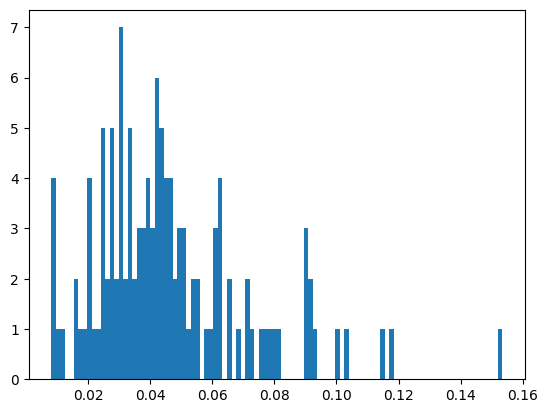

In [79]:
plt.hist(opto_tbl_simple['euc_max_p'], bins=100);

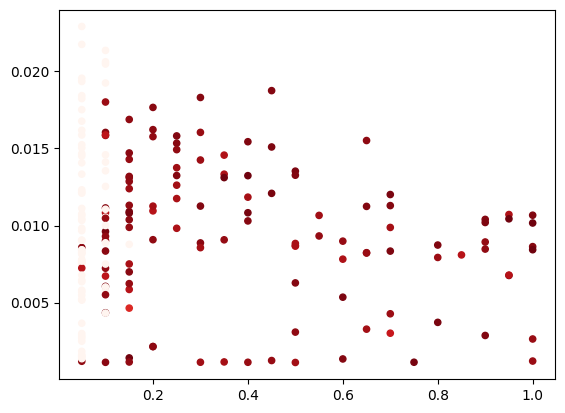

In [77]:
plt.scatter(opto_tbl_simple['max_p'], opto_tbl_simple['min_lat'], c=get_gradient_colors(1-opto_tbl_simple['euc_max_p'], floor=0.5, ceiling=1, cmap_name='Reds'), s=20)

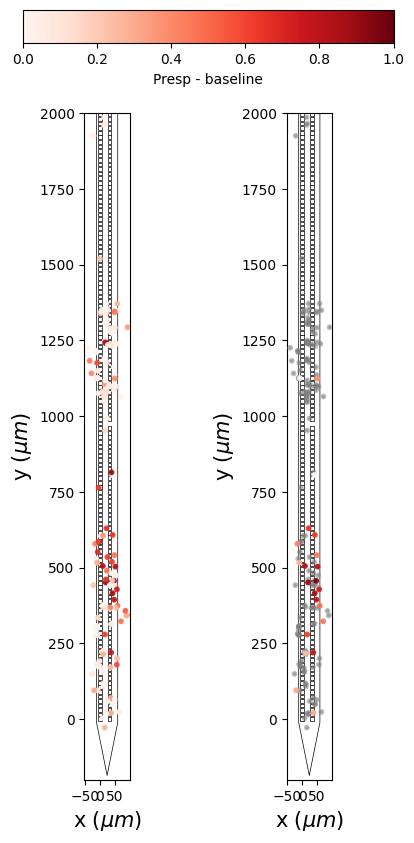

In [231]:
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 4, figure=fig, height_ratios=[1, 20])
ax = fig.add_subplot(gs[1, 0])
colors = get_gradient_colors(max_p-baseline)
color_dict = dict(zip(unit_ids, colors))
w = sw.plot_unit_locations(we, backend="matplotlib", unit_ids=unit_ids, unit_colors=color_dict, ax = ax)
w.ax.set_ylim(-200, 2000)

ax = fig.add_subplot(gs[1, 1])
unit_ids_filtered = pd.Series(unit_ids)[~opto_tbl_simple['decoder_label'].isin(['artifact', 'noise']) & (opto_tbl_simple['mean_lat']>=0.005) & (opto_tbl_simple['euc_max_p']<=0.5)].values.tolist()
w = sw.plot_unit_locations(we, backend="matplotlib", unit_ids=unit_ids_filtered, unit_colors=color_dict, ax = ax)
w.ax.set_ylim(-200, 2000)

# Define the color map (red gradient)
cmap = plt.get_cmap("Reds")  # Use Reds colormap

# Normalize between 0 and 1
norm = mcolors.Normalize(vmin=0, vmax=1)

# Create a colorbar
ax = fig.add_subplot(gs[0, 0:2])
cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax, orientation='horizontal')
cb.set_label("Presp - baseline")

plt.show()


/tmp/ipykernel_28945/232844224.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name)


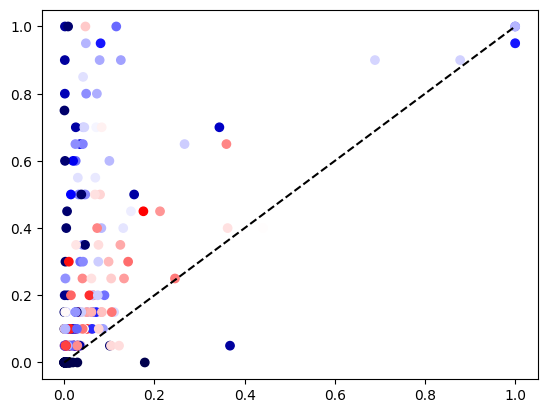

In [153]:
color_map = get_gradient_colors(lat_mean, floor=0, ceiling=0.025, cmap_name='seismic')
plt.scatter(max_p-baseline c=color_map)
plt.plot([0, 1], [0, 1], 'k--')

(array([10.,  2.,  0.,  0.,  2.,  0.,  1.,  0.,  3.,  2.,  0.,  1.,  1.,
         0.,  2.,  0.,  1.,  2.,  1.,  0.,  0.,  4.,  1.,  1.,  3.,  1.,
         3.,  1.,  1.,  1.,  1.,  2.,  0.,  3.,  4.,  5.,  3.,  2.,  3.,
         5.,  2.,  2.,  5.,  4.,  4.,  4.,  6.,  4.,  4.,  2.,  3.,  4.,
         6.,  2.,  1.,  6.,  4.,  2.,  1.,  3.,  3.,  3.,  3.,  2.,  3.,
         2.,  1.,  6.,  3.,  2.,  1.,  1.,  2.,  1.,  1.,  3.,  1.,  2.,
         3.,  2.,  1.,  1.,  0.,  2.,  1.,  0.,  0.,  1.,  2.,  1.,  0.,
         0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([0.00111404, 0.00133208, 0.00155012, 0.00176816, 0.00198621,
        0.00220425, 0.00242229, 0.00264033, 0.00285837, 0.00307641,
        0.00329445, 0.00351249, 0.00373053, 0.00394857, 0.00416662,
        0.00438466, 0.0046027 , 0.00482074, 0.00503878, 0.00525682,
        0.00547486, 0.0056929 , 0.00591094, 0.00612899, 0.00634703,
        0.00656507, 0.00678311, 0.00700115, 0.00721919, 0.00743723,
        0.00765527, 0.0078

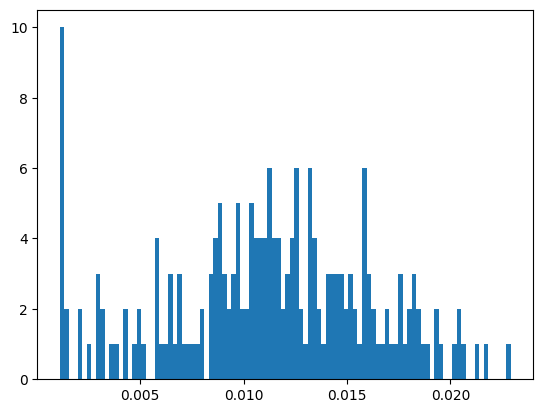

In [150]:
plt.hist(lat_mean, bins=100)

In [143]:
color_map

[(np.float64(1.0),
  np.float64(0.9607843137254902),
  np.float64(0.9411764705882353),
  np.float64(1.0)),
 (np.float64(1.0),
  np.float64(0.9607843137254902),
  np.float64(0.9411764705882353),
  np.float64(1.0)),
 (np.float64(0.9913725490196079),
  np.float64(0.7913725490196079),
  np.float64(0.7082352941176471),
  np.float64(1.0)),
 (np.float64(0.9835755478662053),
  np.float64(0.4127950788158401),
  np.float64(0.28835063437139563),
  np.float64(1.0)),
 (np.float64(0.7364705882352941),
  np.float64(0.08),
  np.float64(0.10117647058823528),
  np.float64(1.0)),
 (np.float64(0.403921568627451),
  np.float64(0.0),
  np.float64(0.05098039215686274),
  np.float64(1.0))]

(-100.0, 2000.0)

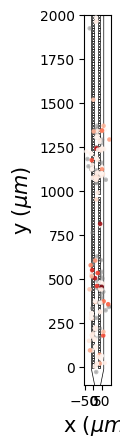

In [112]:
w = sw.plot_unit_locations(we, backend="matplotlib", unit_ids=unit_ids_filtered, unit_colors=color_dict, immediate_plot=True)
w.ax.set_ylim(-100, 2000)
# w.figure.savefig(fname=f'{session}_unit_locations_{target}.pdf')